#1. Prerequsitie

## 1) Mount

In [1]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

# 원하는 경로로 현재 작업 디렉토리 변경 (예: '내 드라이브/내 폴더'로 변경)
path = '/content/drive/My Drive/UNiFMIR-pretrain'  # 원하는 폴더 경로로 수정
os.chdir(path)

# 변경된 경로 확인
print("현재 작업 디렉토리:", os.getcwd())

Mounted at /content/drive
현재 작업 디렉토리: /content/drive/My Drive/UNiFMIR-pretrain


## 2) Basic Dependancies

In [2]:
import faulthandler

faulthandler.enable()

import matplotlib.pyplot as plt
import numpy as np
import os
from decimal import Decimal
import torch.nn.utils as utils
import imageio
import torch
from torch.utils.data import dataloader
import tifffile

import utility
import loss
from model.Unimodel import UniModel
from mydata import normalize, PercentileNormalizer

torch.backends.cudnn.enabled = False
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


#2. Load Pretrained Models & Test

## 1) Load Pretrained model

In [3]:
class Args():
  def __init__(self):
    self.n_resblocks = 64
    self.n_feats = 256
    self.inch = 50
    self.n_colors = 1
    self.scale = [1]
    self.rgb_range = 1
    self.res_scale = 0.1

In [4]:
args = Args()
checkpoint_path = "model_best.pt"  # .pt 파일 경로
state_dict = torch.load(checkpoint_path)  # .pt 파일 로드
model = UniModel(args)
model.load_state_dict(state_dict)

<ipython-input-4-6c7be7a3ada8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path)  # .pt 파일 로드
/content/drive/My Drive/UNiFMIR-pretrai

<All keys matched successfully>

## 2) Data Preparation

In [5]:
import numpy as np
from scipy.ndimage import zoom
import tifffile as tiff

def process_and_save_volume(input_path, output_path, scale_factors):
    """
    Load a 3D TIFF volume, apply trilinear interpolation, and save the result.

    Args:
        input_path (str): Path to the input TIFF file.
        output_path (str): Path to save the interpolated TIFF file.
        scale_factors (tuple): Scale factors for (z, y, x) dimensions, e.g., (1.0, 0.5, 0.5).
    """
    # Load the TIFF volume
    volume = tiff.imread(input_path)
    if len(volume.shape) != 3:
        raise ValueError("Input TIFF file must contain a 3D volume.")

    print(f"Original shape: {volume.shape}")

    # Apply trilinear interpolation
    # `order=1` corresponds to trilinear interpolation
    interpolated_volume = zoom(volume, scale_factors, order=1)[:256, :256, :256]

    print(f"Interpolated shape: {interpolated_volume.shape}")

    # Save the result as a TIFF file
    tiff.imwrite(output_path, interpolated_volume.astype(volume.dtype))
    print(f"Interpolated volume saved to {output_path}")

# Example usage:
# Path to input and output TIFF files
# input_tiff = "/content/drive/MyDrive/UNiFMIR-pretrain/tiff/Liver.tif"
# output_tiff = "/content/drive/MyDrive/UNiFMIR-pretrain/tiff/Liver_XY.tiff"

# Scale factors for each dimension (z, y, x)
# scales = (1.0, 1.0, 1.0)  # Keep z unchanged, reduce y and x dimensions by half

# process_and_save_volume(input_tiff, output_tiff, scales)


## 3) Test for Simulated Neuron Tiff

In [6]:
def plot_one_slice(volume, index=None):
    """
    Plots the z=0 slice of a 3D numpy volume.

    Args:
        volume (numpy.ndarray): A 3D numpy array with shape (D, H, W).
    """
    slice = None

    if len(volume.shape) == 2:
        if volume.shape[0]  == 1 :
            raise ValueError('2 Dimension input, but first dimension = 1')
        else :
            slice = volume

    elif len(volume.shape) == 3:
        if index is None:
            raise ValueError('3 Dimension input, but index is None')
        else :
            slice = volume[index, :, :]

    # Plot the slice
    plt.figure(figsize=(6, 6))
    plt.imshow(slice, cmap='gray', interpolation='nearest')
    plt.title(f"z={index} Slice")
    plt.axis('off')  # Remove axes for better visualization
    plt.colorbar(label='Intensity')
    plt.show()

In [7]:
import matplotlib.pyplot as plt

def plot_images(images, titles=None, cmap='gray'):
    """
    Plots multiple 2D images from a tuple of images.

    Args:
        images (tuple): A tuple of 2D numpy arrays (H, W) to plot.
        titles (list[str], optional): Titles for each image. Defaults to None.
        cmap (str): Colormap to use for plotting. Defaults to 'gray'.
    """
    num_images = len(images)
    cols = int(np.ceil(np.sqrt(num_images)))  # Arrange in a square grid
    rows = int(np.ceil(num_images / cols))

    # Create the plot grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()  # Flatten for easier indexing

    for i, img in enumerate(images):
        if not isinstance(img, np.ndarray) or img.ndim != 2:
            raise ValueError(f"Each image must be a 2D numpy array. Invalid image at index {i}.")

        axes[i].imshow(img, cmap=cmap, interpolation='nearest')
        if titles:
            axes[i].set_title(titles[i])
        else:
            axes[i].set_title(f"Image {i}")
        axes[i].axis('off')  # Remove axes for better visualization

    # Turn off any extra axes in the grid
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [8]:
model.eval()

UniModel(
  (conv_firstsr): Conv2d(1, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsamplesr): Upsample(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PixelShuffle(upscale_factor=2)
  )
  (conv_firstdT): Conv2d(5, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_firstiso): Conv2d(1, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (project): Projhead(
    (sub_mean): MeanShiftC1(1, 1, kernel_size=(1, 1), stride=(1, 1))
    (add_mean): MeanShiftC1(1, 1, kernel_size=(1, 1), stride=(1, 1))
    (head): Sequential(
      (0): Conv2d(50, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (body): ModuleList(
      (0): ENLCA(
        (conv_match1): BasicBlock(
          (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_match2): BasicBlock(
          (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_assembly): BasicBlock(
          (0): Conv2d(25

In [9]:
SimZX = tifffile.imread('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/interpolated_Liver_ZX.tiff')
SimZX_target = SimZX[3]

- Raw input plot

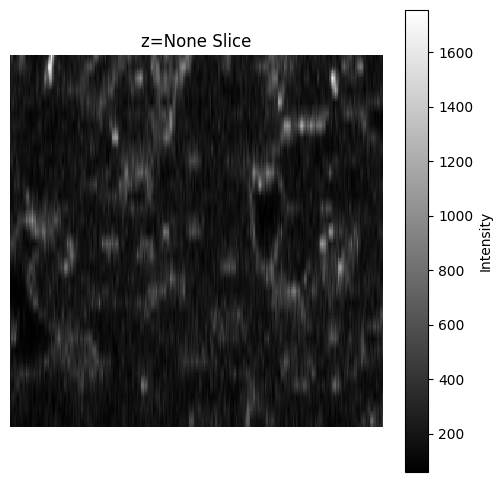

In [10]:
plot_one_slice(SimZX_target)

- input to model

In [11]:
#input = torch.from_numpy(SimZX_target).unsqueeze(0).unsqueeze(0).float()
#output = model(input, tsk=3)
#output = output.squeeze(0).squeeze(0).detach().numpy()
#plot_one_slice(output)

In [12]:
#output.shape

- entire volume restoration

In [13]:
#with torch.no_grad() :
#    model.to('cuda')
#    VolZX = tifffile.imread('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/interpolated_Liver_ZX.tiff')
#    input = torch.from_numpy(VolZX).unsqueeze(0).unsqueeze(0).float()
#    output = torch.zeros_like(input)
#
#    for i in range(0,VolZX.shape[0]):
#        print(f'{i}th')
#        image = input[:, :, i, :, :].to('cuda')
#        output[:, :, i, :, :] = model(image, tsk=3).to('cpu')
#
#
#    output = output.squeeze(0).squeeze(0).detach().numpy()
#    #tifffile.imwrite('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/restored_Liver_ZX.tiff', output)
#    print('done!')

# 3. Solution for all-in-one isotropic reconstruction

## 1) Hypothesis



Use the degradation representation during the isotropic restoration of image. The image should be well reconstructed, regardless of the degradation parameter, and this will be evaluated by $L_{rec}$. For the generalization probability, any reconstruction will be proceeded with "estimated degradation representation vector" given. Therefore, the network will be trained to "output the fine-restoration for various range of degradation process, given the degradation estimator for the conditional generation".


For each iteration, pair of base images will be used : $XY_{original}, XY_{degraded}$. Since $XY_{degraded}$ is obtained by applying degradation process to $XY_{original}$, two images have similar structure.

The optimal degradation representation by comparing the embedding of $XY_{degraded}$ and random flipped $XY_{original}$. Flipping enables the model to focus on the difference of "quality", not the difference of structure.

This degradation representation is then utilized while decoding, in addition to the embedding of $XY_{degraded}$. Decoder will use this additional information to adjust to various degradation process, and match the $XY_{original}$.


## 2) Custom UniModel Preparation

In [14]:
for i in model._modules:
  print(i)

conv_firstsr
upsamplesr
conv_firstdT
conv_firstiso
project
conv_firstproj
conv_first0
conv_firstv
conv_before_upsamplev
conv_lastv
patch_embed
patch_unembed
pos_drop
layers
norm
conv_after_body
conv_before_upsample0
upsample
conv_last0


- Load UniModel to prototype model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Test_UniModel(nn.Module):
  def __init__(self, pretrained):
    super(Test_UniModel, self).__init__()
    self.img_range = pretrained.img_range
    self.check_image_size = pretrained.check_image_size
    self.mean = pretrained.mean

    self.conv_first = pretrained.conv_firstiso
    self.conv_after_body = pretrained.conv_after_body
    self.conv_before_upsample0 = pretrained.conv_before_upsample0
    self.upsample = pretrained.upsample
    self.conv_last0 = pretrained.conv_last0

    self.patch_embed = pretrained.patch_embed
    self.pos_drop = pretrained.pos_drop
    self.layers = pretrained.layers
    self.norm = pretrained.norm
    self.patch_unembed = pretrained.patch_unembed


  def forward(self, x):
    # ~~~~~~~~~~~~~ Head ~~~~~~~~~~~~~ #
    x = self.check_image_size(x)
    print(f'initial shape : {x.shape}')
    self.mean = self.mean.type_as(x)
    x = (x - self.mean) * self.img_range
    x = self.conv_first(x)
    print(f'shape after conv_first : {x.shape}')
    res_1 = x

    # ~~~~~~~~~~~~~ Feature enhancement ~~~~~~~~~~~~~ #
    xfe = self.conv_after_body(self.forward_features(x))
    print(f'shape after feature enhancement : {x.shape}')
    res_2 = xfe
    x = xfe + x
    res_3 = x

    # ~~~~~~~~~~~~~ Tail ~~~~~~~~~~~~~~ #
    x = self.conv_before_upsample0(x)
    print(f'shape after conv_before_upsample0 : {x.shape}')
    res_4 = x

    x = self.upsample(x)
    x = self.conv_last0(x)
    print(f'shape after conv_last0 : {x.shape}')
    res_5 = x

    x = x / self.img_range + self.mean
    res_6 = x

    return x, res_1, res_2, res_3, res_4, res_5, res_6

  def forward_features(self, x):
    x_size = (x.shape[2], x.shape[3])
    x = self.patch_embed(x)
    x = self.pos_drop(x)
    for layer in self.layers:
        x = layer(x, x_size)
    x = self.norm(x)
    x = self.patch_unembed(x, x_size)
    return x

In [16]:
test_model = Test_UniModel(model.to('cpu'))
test_model.eval()

Test_UniModel(
  (conv_first): Conv2d(1, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_after_body): Conv2d(90, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_before_upsample0): Sequential(
    (0): Conv2d(90, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (upsample): Upsample()
  (conv_last0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=90, input_resolution=(64, 64), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=90, input_resolution=(64, 64), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2.0
            (norm1): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
            (attn): WindowA

- Visualize output

In [17]:
with torch.no_grad():
    test = torch.from_numpy(tifffile.imread('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/interpolated_dendrite_ZX.tiff')[0]).unsqueeze(0).unsqueeze(0).float()
    res = test_model(test)

for i in res :
  print(i.shape)

initial shape : torch.Size([1, 1, 224, 224])
shape after conv_first : torch.Size([1, 90, 224, 224])
shape after feature enhancement : torch.Size([1, 90, 224, 224])
shape after conv_before_upsample0 : torch.Size([1, 32, 224, 224])
shape after conv_last0 : torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 90, 224, 224])
torch.Size([1, 90, 224, 224])
torch.Size([1, 90, 224, 224])
torch.Size([1, 32, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])


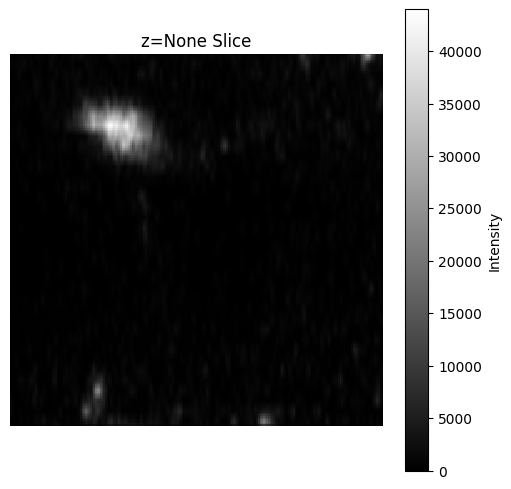

In [18]:
# output
plot_one_slice(res[0].squeeze().detach().numpy())

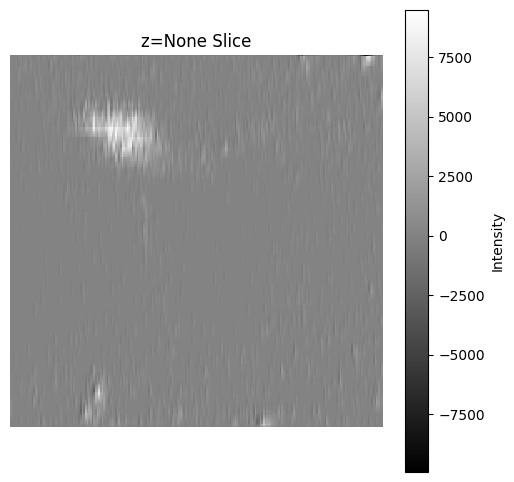

In [19]:
# after conv_first (head)
plot_one_slice(res[1][0,35,:,:].squeeze().detach().numpy())

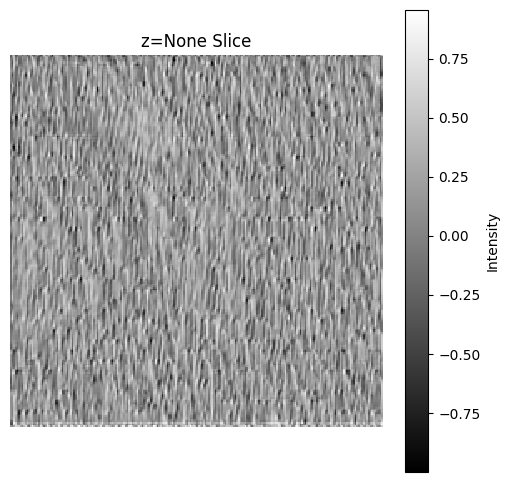

In [20]:
# after feature enhancement (latent)
plot_one_slice(res[2][0,35,:,:].squeeze().detach().numpy())

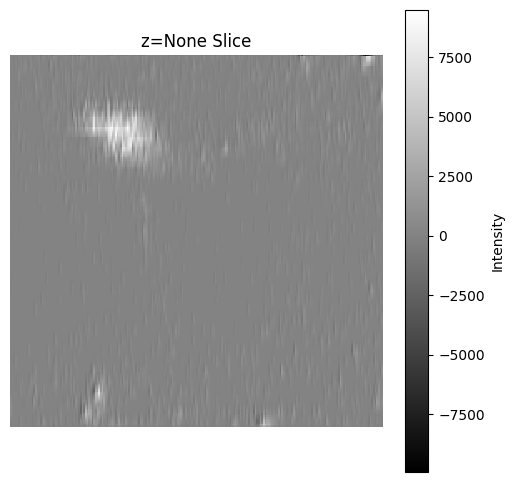

In [21]:
# after feature enhancement + x (latent)
plot_one_slice(res[3][0,35,:,:].squeeze().detach().numpy())

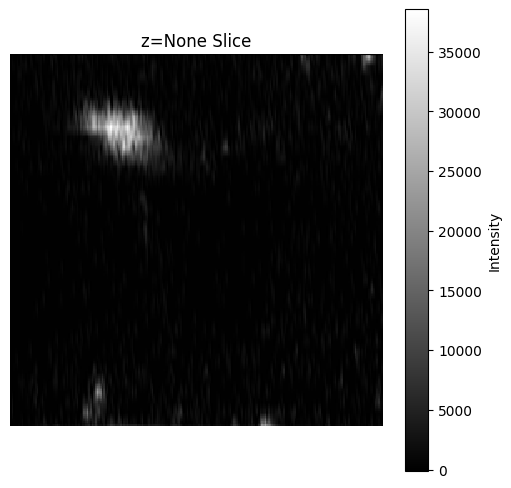

In [22]:
# after conv_before_upsample (tail)
plot_one_slice(res[4][0,5,:,:].squeeze().detach().numpy())

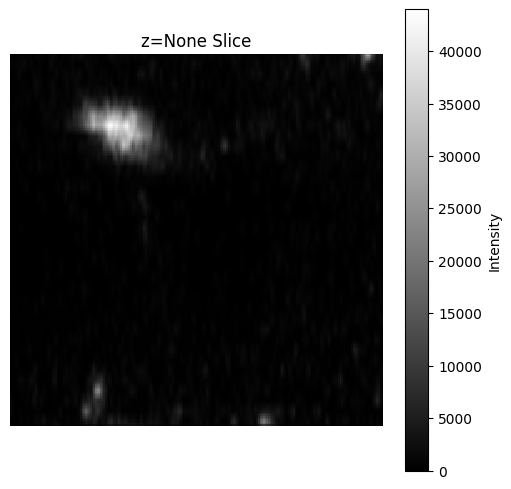

In [23]:
# after conv_last0 (tail)
plot_one_slice(res[5].squeeze().detach().numpy())

- Modify the architecture

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchAttentionModule(nn.Module):
    def __init__(self, feature_dim, patch_size, num_prompts):
        """
        Args:
            feature_dim: Channel dimension of the intermediate image.
            patch_size: Size of the patches (e.g., 4x4).
            num_prompts: Number of 4x4 prompt patches.
        """
        super(PatchAttentionModule, self).__init__()
        self.patch_size = patch_size
        self.num_prompts = num_prompts

        # Learnable 4x4 prompt patches
        self.prompts = nn.Parameter(torch.randn(num_prompts, feature_dim, patch_size, patch_size))
        nn.init.xavier_uniform_(self.prompts)

        # Q, K, V transformations
        self.query_transform = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)
        self.key_transform = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)
        self.value_transform = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)

    def extract_patches(self, x, patch_size):
        """
        Divides the input image into non-overlapping patches.
        Args:
            x: [B, C, H, W] input tensor
            patch_size: Size of the patches
        Returns:
            patches: [B, num_patches, C, patch_size, patch_size]
        """
        B, C, H, W = x.shape
        x_unf = F.unfold(x, kernel_size=patch_size, stride=patch_size)
        num_patches = x_unf.shape[-1]  # Number of patches
        patches = x_unf.reshape(B, C, patch_size, patch_size, num_patches).permute(0, 4, 1, 2, 3)
        return patches  # [B, num_patches, C, patch_size, patch_size]

    def forward(self, features):
        """
        Args:
            features: [B, C, H, W] - intermediate image tensor

        Returns:
            refined_features: [B, C, H, W] - refined image tensor
        """
        B, C, H, W = features.shape

        #  Extract patches from intermediate features
        patches = self.extract_patches(features, self.patch_size) # [B, num_patches, C, 4, 4]

        # Reshape for QKV transformations
        num_patches = patches.shape[1]
        patches = patches.reshape(B * num_patches, C, self.patch_size, self.patch_size)  # Flatten patches

        # QKV transformations
        query = self.query_transform(patches)  # [B*num_patches, C, 4, 4]
        key = self.key_transform(self.prompts)  # [num_prompts, C, 4, 4]
        value = self.value_transform(self.prompts)  # [num_prompts, C, 4, 4]

        # Compute attention scores (Query x Key)
        query_flat = query.view(B * num_patches, -1)  # [B*num_patches, C*4*4]
        key_flat = key.view(self.num_prompts, -1).T  # [C*4*4, num_prompts]
        attn_scores = torch.matmul(query_flat, key_flat)  # [B*num_patches, num_prompts]

        # Softmax normalization
        attn_weights = torch.softmax(attn_scores, dim=-1)  # [B*num_patches, num_prompts]

        # Attention-weighted sum of Value
        value_flat = value.view(self.num_prompts, -1)  # [num_prompts, C*4*4]
        weighted_value = torch.matmul(attn_weights, value_flat)  # [B*num_patches, C*4*4]
        refined_patches = weighted_value.view(B, num_patches, C, self.patch_size, self.patch_size)

        # Reconstruct the image from refined patches
        refined_patches_flat = refined_patches.permute(0, 2, 3, 4, 1).contiguous().view(B, C * self.patch_size * self.patch_size, -1)
        refined_features = F.fold(refined_patches_flat, output_size=(H, W), kernel_size=self.patch_size, stride=self.patch_size)

        return refined_features


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from timm.models.layers import trunc_normal_

class Custom_UniModel(nn.Module):
  def __init__(self, pretrained):
    super(Custom_UniModel, self).__init__()

    self.img_range = pretrained.img_range
    self.check_image_size = pretrained.check_image_size
    self.mean = pretrained.mean

    self.conv_before_upsample0 = pretrained.conv_before_upsample0
    self.upsample = pretrained.upsample
    self.conv_last0 = pretrained.conv_last0
    self.apply(self._initialize_weights)

    self.conv_first = pretrained.conv_firstiso
    self.conv_after_body = pretrained.conv_after_body

    self.patch_embed = pretrained.patch_embed
    self.pos_drop = pretrained.pos_drop
    self.layers = pretrained.layers

    self.norm = pretrained.norm
    self.patch_unembed = pretrained.patch_unembed

    self.patchattention_1 = PatchAttentionModule(90, 8, 16)
    self.patchattention_2 = PatchAttentionModule(32, 8, 16)

  def forward(self, x):
    with torch.no_grad():
      # ~~~~~~~~~~~~~ Head ~~~~~~~~~~~~~ #
      x = self.check_image_size(x)
      self.mean = self.mean.type_as(x)
      x = (x - self.mean) * self.img_range
      x = self.conv_first(x)
      # ~~~~~~~~~~~~~ Feature enhancement ~~~~~~~~~~~~~ #
      xfe = (self.forward_features(x))
      xfe = self.conv_after_body(xfe)

    # ~~~~~~~~~~~~~ Tail ~~~~~~~~~~~~~~ #
    x = xfe + x
    x = x + self.patchattention_1(x)
    x = self.conv_before_upsample0(x)
    x = self.upsample(x)
    x = x + self.patchattention_2(x)
    x = self.conv_last0(x)
    x = x / self.img_range + self.mean

    return x

  def forward_features(self, x):
    x_size = (x.shape[2], x.shape[3])
    x = self.patch_embed(x)
    x = self.pos_drop(x)
    for layer in self.layers:
        x = layer(x, x_size)
    x = self.norm(x)
    x = self.patch_unembed(x, x_size)
    return x

  def _initialize_weights(self, m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

In [26]:
custom_model = Custom_UniModel(model.to('cuda')).to('cuda')

## 3) Training The Model

In [27]:
import torch
import torch.nn.functional as F

def degradation(slice, mode = '4_avg_downsample'):
  if mode == '4_avg_downsample' :
    # Input shape: (1, 1, 256, 256)

    # Step 1: Downsampling - average pooling along the Y-axis
    # Kernel size (4, 1) with stride (4, 1) to only reduce along the Y-axis
    downsampled = F.avg_pool2d(slice, kernel_size=(4, 1), stride=(4, 1))
    # Shape: (1, 1, 64, 256)

    # Step 2: Upsampling - bilinear interpolation to return to original size
    upsampled = F.interpolate(downsampled, size=(256, 256), mode='bilinear', align_corners=False)
    # Shape: (1, 1, 256, 256)

  if mode == '8_avg_downsample' :
    # Input shape: (1, 1, 256, 256)

    # Step 1: Downsampling - average pooling along the Y-axis
    # Kernel size (8, 1) with stride (8, 1) to only reduce along the Y-axis
    downsampled = F.avg_pool2d(slice, kernel_size=(8, 1), stride=(8, 1))
    # Shape: (1, 1, 32, 256)

    # Step 2: Upsampling - bilinear interpolation to return to original size
    upsampled = F.interpolate(downsampled, size=(256, 256), mode='bilinear', align_corners=False)
    # Shape: (1, 1, 256, 256)

  return upsampled

In [28]:
# Optim
optimizer = torch.optim.AdamW([
    {'params': custom_model.patchattention_1.parameters(), 'lr': 0.01},  # 첫 번째 그룹
    {'params': custom_model.patchattention_2.parameters(), 'lr': 0.01}   # 두 번째 그룹
])

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MS_SSIM_L1_LOSS(nn.Module):
    # Have to use cuda, otherwise the speed is too slow.
    def __init__(self, gaussian_sigmas=[0.5, 1.0, 2.0, 4.0, 8.0],
                 data_range = 7.0,
                 K=(0.01, 0.03),
                 alpha=0.4,
                 compensation=200.0,
                 cuda_dev=0,):
        super(MS_SSIM_L1_LOSS, self).__init__()
        self.DR = data_range
        self.C1 = (K[0] * data_range) ** 2
        self.C2 = (K[1] * data_range) ** 2
        self.pad = int(2 * gaussian_sigmas[-1])
        self.alpha = alpha
        self.compensation=compensation
        filter_size = int(4 * gaussian_sigmas[-1] + 1)
        g_masks = torch.zeros((3*len(gaussian_sigmas), 1, filter_size, filter_size))
        for idx, sigma in enumerate(gaussian_sigmas):
            # r0,g0,b0,r1,g1,b1,...,rM,gM,bM
            g_masks[3*idx+0, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3*idx+1, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3*idx+2, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
        self.g_masks = g_masks.cuda(cuda_dev)

    def _fspecial_gauss_1d(self, size, sigma):
        """Create 1-D gauss kernel
        Args:
            size (int): the size of gauss kernel
            sigma (float): sigma of normal distribution

        Returns:
            torch.Tensor: 1D kernel (size)
        """
        coords = torch.arange(size).to(dtype=torch.float)
        coords -= size // 2
        g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
        g /= g.sum()
        return g.reshape(-1)

    def _fspecial_gauss_2d(self, size, sigma):
        """Create 2-D gauss kernel
        Args:
            size (int): the size of gauss kernel
            sigma (float): sigma of normal distribution

        Returns:
            torch.Tensor: 2D kernel (size x size)
        """
        gaussian_vec = self._fspecial_gauss_1d(size, sigma)
        return torch.outer(gaussian_vec, gaussian_vec)

    def forward(self, x, y):
        b, c, h, w = x.shape
        mux = F.conv2d(x, self.g_masks, groups=1, padding=self.pad)
        muy = F.conv2d(y, self.g_masks, groups=1, padding=self.pad)

        mux2 = mux * mux
        muy2 = muy * muy
        muxy = mux * muy

        sigmax2 = F.conv2d(x * x, self.g_masks, groups=1, padding=self.pad) - mux2
        sigmay2 = F.conv2d(y * y, self.g_masks, groups=1, padding=self.pad) - muy2
        sigmaxy = F.conv2d(x * y, self.g_masks, groups=1, padding=self.pad) - muxy

        # l(j), cs(j) in MS-SSIM
        l  = (2 * muxy    + self.C1) / (mux2    + muy2    + self.C1)  # [B, 15, H, W]
        cs = (2 * sigmaxy + self.C2) / (sigmax2 + sigmay2 + self.C2)

        lM = l[:, 0, :, :]
        PIcs = cs.prod(dim=1)

        loss_ms_ssim = 1 - lM*PIcs  # [B, H, W]

        loss_l1 = F.l1_loss(x, y, reduction='none')  # [B, 3, H, W]
        # average l1 loss in 3 channels
        gaussian_l1 = F.conv2d(loss_l1, self.g_masks.narrow(dim=0, start=-3, length=3),
                               groups=1, padding=self.pad).mean(1)  # [B, H, W]

        loss_mix = self.alpha * loss_ms_ssim + (1 - self.alpha) * gaussian_l1 / self.DR
        loss_mix = self.compensation*loss_mix

        return loss_mix.mean()


loss_function = MS_SSIM_L1_LOSS(cuda_dev=0)

#### LIVER

In [ ]:
custom_model.train()
Data = tifffile.imread('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/interpolated_Liver_XY.tiff')
Data_tensor = torch.from_numpy(Data).float() / 255
batch_size = 8

input_batch = []
target_batch = []

for i in range(Data_tensor.shape[0]//batch_size) :
    input_batch.append(Data_tensor[i*8 : (i+1)*8, :, :])
    target_batch.append(Data_tensor[i*8 : (i+1)*8, :, :])

input_batch = torch.stack(input_batch, dim=0).unsqueeze(2)
target_batch = torch.stack(target_batch, dim=0).unsqueeze(2)

target_tensor = 0
output = 0

# Loss 계산 후 Backpropagation 및 Update
for epoch in range(25):
    print(f'epoch.......{epoch}')
    for i in range(input_batch.shape[0]):
        print(f'    slice.......{i}')
        optimizer.zero_grad()

        target_tensor = target_batch[i].to('cuda')
        input_tensor  = degradation(input_batch[i], mode='8_avg_downsample').to('cuda')
        output = custom_model(input_tensor)

        loss = loss_function(output, target_tensor)
        loss.backward()
        optimizer.step()
        print(input_tensor.max(), output.max())
        plot_images((target_tensor[0].to('cpu').squeeze().detach().numpy() ,
                     input_tensor[0].to('cpu').squeeze().detach().numpy(),
                     output[0].to('cpu').squeeze().detach().numpy()))

        print(f'    loss : {loss.item()}')

In [35]:
import torch

def calculate_psnr(target_tensor, output_tensor, max_pixel_value=255.0):
    """
    Calculate PSNR between target and output tensors.

    Args:
        target_tensor (torch.Tensor): Ground truth tensor of shape (B, C, H, W).
        output_tensor (torch.Tensor): Predicted tensor of shape (B, C, H, W).
        max_pixel_value (float): Maximum possible pixel value.

    Returns:
        float: PSNR value in decibels.
    """
    mse = torch.mean((target_tensor - output_tensor) ** 2)  # Mean Squared Error
    if mse == 0:
        return float('inf')  # Perfect reconstruction has infinite PSNR
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))  # PSNR formula
    return psnr.item()

psnr_value = calculate_psnr(target_tensor, output)
print(f"PSNR: {psnr_value:.2f} dB")

target_tensor = target_tensor.to('cpu')
output = output.to('cpu')

PSNR: 59.42 dB


In [50]:
Data = tifffile.imread('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/interpolated_Liver_ZX.tiff')
Data_tensor = torch.from_numpy(Data).float() / 255
Partial = Data_tensor[[64, 128, 192], :, :].unsqueeze(1).to('cuda')
Partial_output = custom_model(Partial)

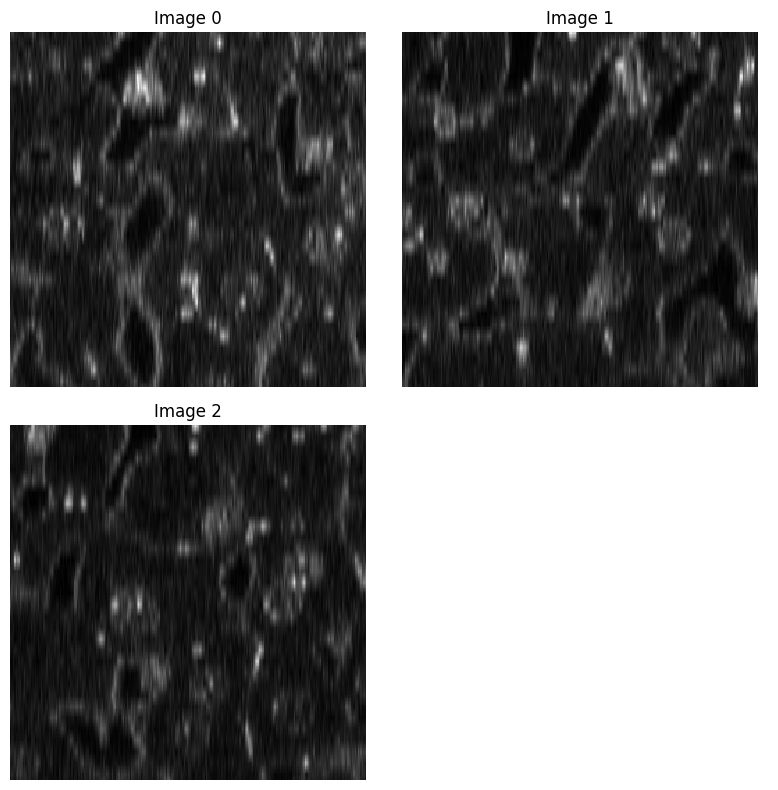

In [51]:
plot_images((Partial[0].to('cpu').squeeze().detach().numpy() ,
              Partial[1].to('cpu').squeeze().detach().numpy(),
              Partial[2].to('cpu').squeeze().detach().numpy()))

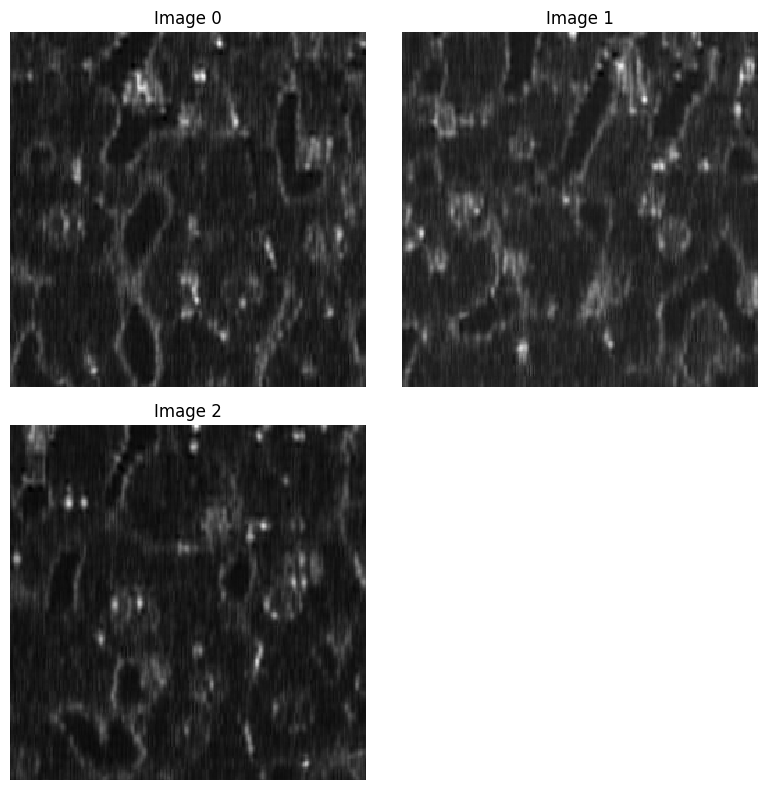

In [52]:
plot_images((Partial_output[0].to('cpu').squeeze().detach().numpy() ,
              Partial_output[1].to('cpu').squeeze().detach().numpy(),
              Partial_output[2].to('cpu').squeeze().detach().numpy()))

#### FIB

In [54]:
custom_model = Custom_UniModel(model.to('cuda')).to('cuda')
# Optim
optimizer = torch.optim.AdamW([
    {'params': custom_model.patchattention_1.parameters(), 'lr': 0.01},  # 첫 번째 그룹
    {'params': custom_model.patchattention_2.parameters(), 'lr': 0.01}   # 두 번째 그룹
])
loss_function = MS_SSIM_L1_LOSS(cuda_dev=0)

In [ ]:
custom_model.train()
Data = tifffile.imread('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/interpolated_FIB_XY.tiff')
Data_tensor = torch.from_numpy(Data).float() / 255
batch_size = 8

input_batch = []
target_batch = []

for i in range(Data_tensor.shape[0]//batch_size) :
    input_batch.append(Data_tensor[i*8 : (i+1)*8, :, :])
    target_batch.append(Data_tensor[i*8 : (i+1)*8, :, :])

input_batch = torch.stack(input_batch, dim=0).unsqueeze(2)
target_batch = torch.stack(target_batch, dim=0).unsqueeze(2)

target_tensor = 0
output = 0

# Loss 계산 후 Backpropagation 및 Update
for epoch in range(25):
    print(f'epoch.......{epoch}')
    for i in range(input_batch.shape[0]):
        print(f'    slice.......{i}')
        optimizer.zero_grad()

        target_tensor = target_batch[i].to('cuda')
        input_tensor  = degradation(input_batch[i], mode='8_avg_downsample').to('cuda')
        output = custom_model(input_tensor)

        loss = loss_function(output, target_tensor)
        loss.backward()
        optimizer.step()
        print(input_tensor.max(), output.max())
        plot_images((target_tensor[0].to('cpu').squeeze().detach().numpy() ,
                     input_tensor[0].to('cpu').squeeze().detach().numpy(),
                     output[0].to('cpu').squeeze().detach().numpy()))

        print(f'    loss : {loss.item()}')

In [56]:
import torch

def calculate_psnr(target_tensor, output_tensor, max_pixel_value=255.0):
    """
    Calculate PSNR between target and output tensors.

    Args:
        target_tensor (torch.Tensor): Ground truth tensor of shape (B, C, H, W).
        output_tensor (torch.Tensor): Predicted tensor of shape (B, C, H, W).
        max_pixel_value (float): Maximum possible pixel value.

    Returns:
        float: PSNR value in decibels.
    """
    mse = torch.mean((target_tensor - output_tensor) ** 2)  # Mean Squared Error
    if mse == 0:
        return float('inf')  # Perfect reconstruction has infinite PSNR
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))  # PSNR formula
    return psnr.item()

psnr_value = calculate_psnr(target_tensor, output)
print(f"PSNR: {psnr_value:.2f} dB")

target_tensor = target_tensor.to('cpu')
output = output.to('cpu')

PSNR: 78.97 dB


In [57]:
Data = tifffile.imread('/content/drive/MyDrive/UNiFMIR-pretrain/tiff/interpolated_FIB_ZX.tiff')
Data_tensor = torch.from_numpy(Data).float() / 255
Partial = Data_tensor[[64, 128, 192], :, :].unsqueeze(1).to('cuda')
Partial_output = custom_model(Partial)

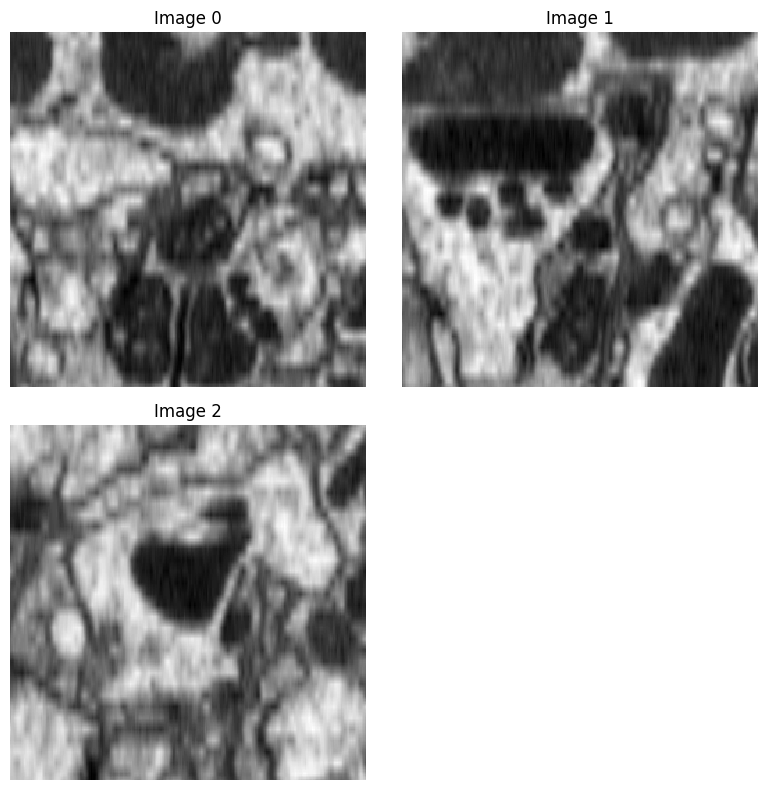

In [58]:
plot_images((Partial[0].to('cpu').squeeze().detach().numpy() ,
              Partial[1].to('cpu').squeeze().detach().numpy(),
              Partial[2].to('cpu').squeeze().detach().numpy()))

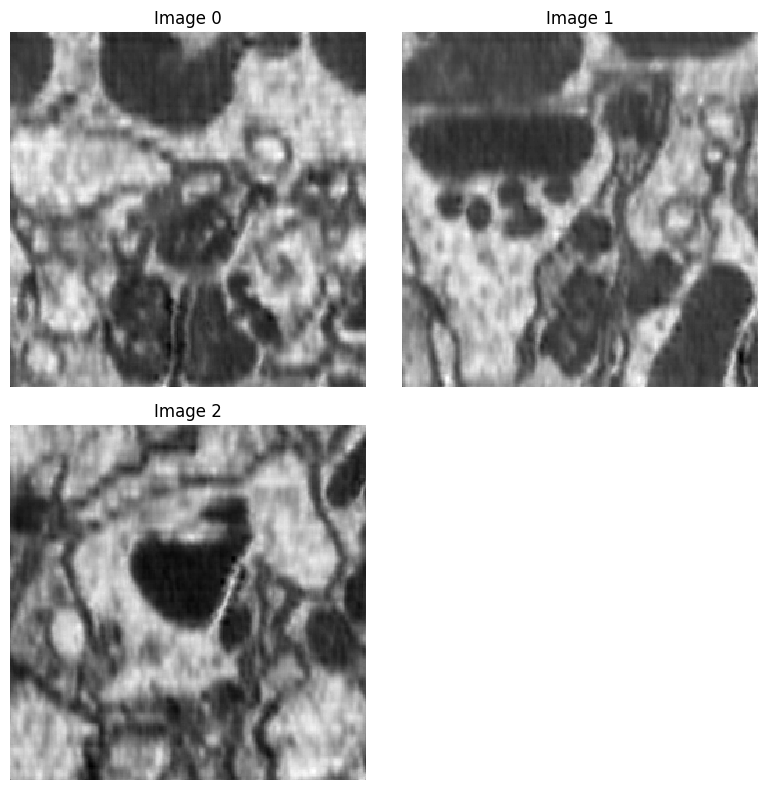

In [59]:
plot_images((Partial_output[0].to('cpu').squeeze().detach().numpy() ,
              Partial_output[1].to('cpu').squeeze().detach().numpy(),
              Partial_output[2].to('cpu').squeeze().detach().numpy()))